# Evaluation

## Objectif

L'objectif de cette évaluation est de parvenir à détecter si une requête est une tentative d'intrusion ou bien une requête légitime.

Votre modèle devrait obtenir un score de 95%.

## Livrable

Vous devrez compléter ce notebook Jupyter et répondre aux questions du Google Form associé [EPSI - PARIS - 2026 - TRDE707 - TP Noté](https://forms.gle/ZhcULFdgYDDm4P7Q9).

## Dépendances et modules

Les modules disponibles pour l'exécution de ce notebook sont :
* pandas
* scikit-learn
* matplotlib

## Source de données

Les sources de données sont des fichiers au format CSV. Vous pouvez les télécharger depuis le dossier [trde707-datasets](https://drive.google.com/drive/folders/1YmNxtXDhiyzoyH6R6twWudgdjUAYvsNo?usp=sharing).

L'archive public_network_log.zip contient un unique fichier public_network_log.csv qui représente un log de requêtes identifiées comme une tentative d'intrusion ou une requête légitime.

L'archive dbip-country-lite-2026-01.zip contient un unique fichier dbip-country-lite-2026-01.csv qui associe à chaque plage d'IP un code Pays. Cette base de données est issue du portail [dbip](https://db-ip.com/db/format/ip-to-country/csv.html).


Charger les données


In [59]:
import pandas as pd

log_df = pd.read_csv("public_network_logs.csv")
country_df = pd.read_csv("dbip-country-lite-2026-01.csv",
                         names=["start_ip", "end_ip", "country"])


Afficher les effectifs de la colonne `Intrusion`.


In [60]:
log_df["Intrusion"].value_counts()


Intrusion
0    6400
1     676
Name: count, dtype: int64

Afficher les 2 représentations les plus adaptées à la colonne `Payload_Size`.


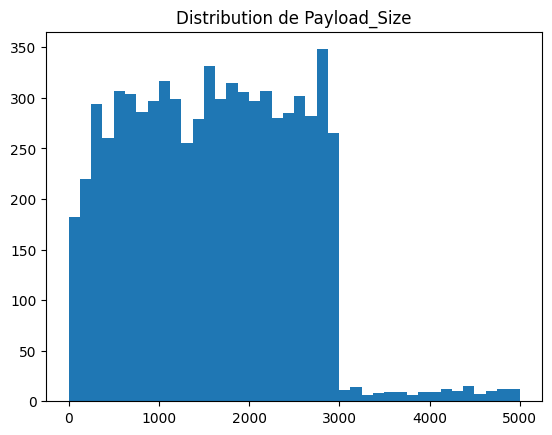

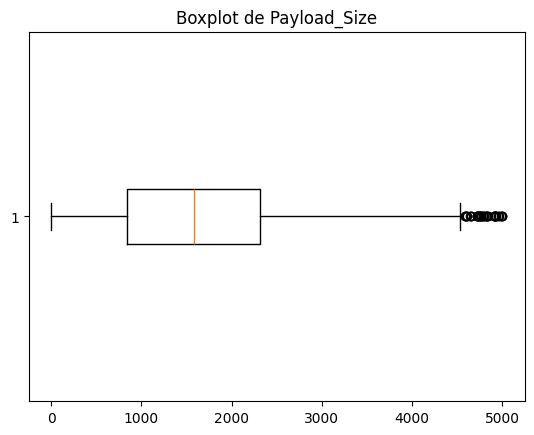

In [61]:
import matplotlib.pyplot as plt

plt.hist(log_df["Payload_Size"], bins=40)
plt.title("Distribution de Payload_Size")
plt.show()

plt.boxplot(log_df["Payload_Size"], vert=False)
plt.title("Boxplot de Payload_Size")
plt.show()


Afficher la représentation la plus adaptée à `Port`.


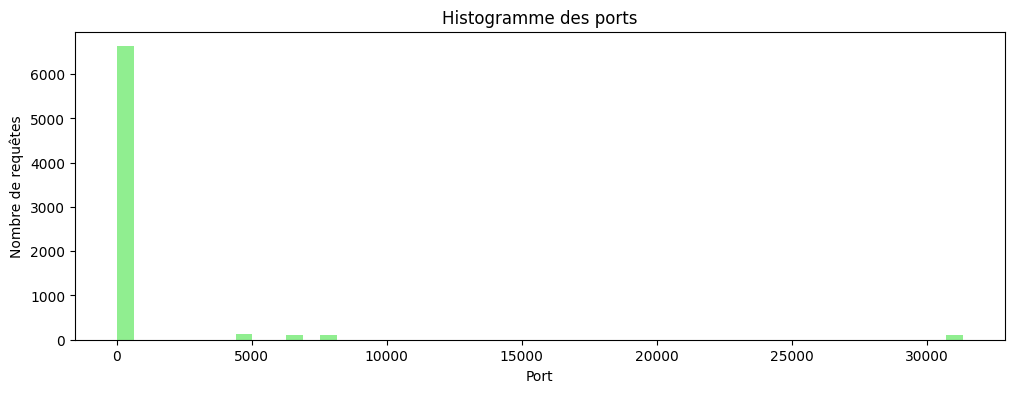

In [62]:
# Histogramme des ports
plt.figure(figsize=(12,4))
plt.hist(log_df['Port'], bins=50, color='lightgreen')
plt.title("Histogramme des ports")
plt.xlabel("Port")
plt.ylabel("Nombre de requêtes")
plt.show()


Afficher sur un même graphique les variables `Payload_Size`, `Port` et `Intrusion`.


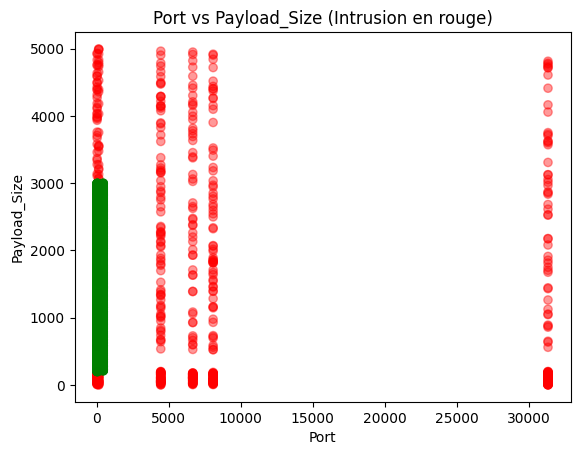

In [63]:
colors = log_df["Intrusion"].map({0: "green", 1: "red"})

plt.scatter(log_df["Port"], log_df["Payload_Size"], c=colors, alpha=0.4)
plt.xlabel("Port")
plt.ylabel("Payload_Size")
plt.title("Port vs Payload_Size (Intrusion en rouge)")
plt.show()


Sélectionner les colonnes pour lesquelles un encodage est nécessaire.


In [64]:
categorical_cols = ['Request_Type','Protocol','User_Agent','Status','Country'] 


Sélectionner les colonnes pour lesquelles une standardisation est nécessaire.


In [65]:
numeric_cols = ['Payload_Size', 'Port']  

Sélectionner un modèle et l'entrainer.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X = log_df.drop(columns=[
    "Intrusion",
    "Scan_Type",        
    "Source_IP",
    "Destination_IP"
])

y = log_df["Intrusion"]


categorical_cols = [
    "Request_Type",
    "Protocol",
    "User_Agent",
    "Status"
]


numeric_cols = [
    "Port",
    "Payload_Size"
]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

model = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=150,
        random_state=42,
        class_weight="balanced"
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

Evaluer les performances de votre modèle.

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1267
           1       0.99      0.91      0.95       149

    accuracy                           0.99      1416
   macro avg       0.99      0.96      0.97      1416
weighted avg       0.99      0.99      0.99      1416



Choisir un affichage permettant de restituer les performances du modèle sélectionné.

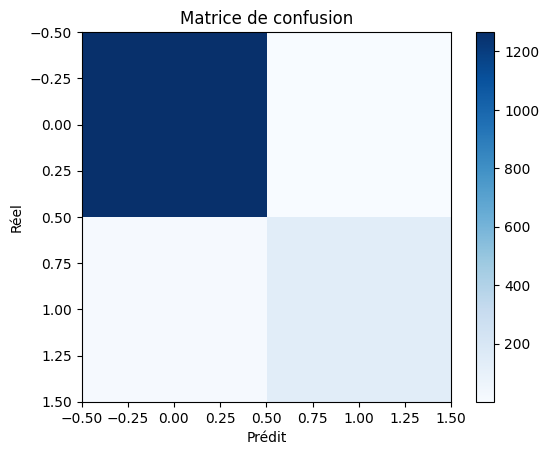

In [68]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()
plt.show()


In [79]:
import pandas as pd

# Charger les fichiers
log_df = pd.read_csv('public_network_logs.csv')
country_df = pd.read_csv('dbip-country-lite-2026-01.csv', header=None, names=['start_ip', 'end_ip', 'country'])

# Ne garder que les IPv4
df_logs_ipv4 = log_df[log_df['Source_IP'].str.count('\.') == 3].copy()
df_geo_ipv4 = country_df[country_df['start_ip'].str.count('\.') == 3].copy()

# Fonction pour convertir IP en entier
def ip_to_int(series):
    ips = series.str.split('.', expand=True).astype(int)
    return (ips[0]*16777216) + (ips[1]*65536) + (ips[2]*256) + ips[3]

# Conversion en entier
df_logs_ipv4['ip_int'] = ip_to_int(df_logs_ipv4['Source_IP'])
df_geo_ipv4['start_int'] = ip_to_int(df_geo_ipv4['start_ip'])
df_geo_ipv4['end_int'] = ip_to_int(df_geo_ipv4['end_ip'])

# Trier pour merge_asof
df_logs_ipv4 = df_logs_ipv4.sort_values('ip_int')
df_geo_ipv4 = df_geo_ipv4.sort_values('start_int')

# Merge asof pour trouver la plage correspondante
merged = pd.merge_asof(df_logs_ipv4, df_geo_ipv4, left_on='ip_int', right_on='start_int')

# Garder uniquement les IP dans la plage
valid_matches = merged[merged['ip_int'] <= merged['end_int']]

# Pays le plus représenté
top_country = valid_matches[valid_matches['country'] != 'ZZ']['country'].value_counts().idxmax()
print("Pays le plus représenté :", top_country)

# Top 5 pays
print(valid_matches[valid_matches['country'] != 'ZZ']['country'].value_counts().head(5))


<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
C:\Users\mirti\AppData\Local\Temp\ipykernel_31376\3194306798.py:8: SyntaxWarning: invalid escape sequence '\.'
  df_logs_ipv4 = log_df[log_df['Source_IP'].str.count('\.') == 3].copy()
C:\Users\mirti\AppData\Local\Temp\ipykernel_31376\3194306798.py:9: SyntaxWarning: invalid escape sequence '\.'
  df_geo_ipv4 = country_df[country_df['start_ip'].str.count('\.') == 3].copy()


Pays le plus représenté : US
country
US    221
CO     67
RU     50
NG     46
FR     45
Name: count, dtype: int64
